### 0. 建立环境

In [29]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [30]:
env = gym.make('FrozenLake-v1')
n_games = 1000
win_pct = []
scores = []

In [31]:
# 查看有哪些动作
print(list(range(env.action_space.n)))
# 随机选择一个动作
env.action_space.sample()

[0, 1, 2, 3]


0

### 1. 先用随机策略看看得分情况

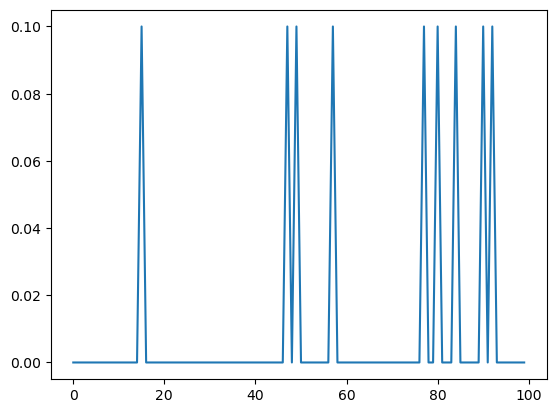

In [32]:
# 随机选择动作，并计算得分
for i in range(n_games):
    done = False
    obs = env.reset()
    score = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        score += reward
        done = done or truncated  # Ensure the loop exits if the episode is truncated
    scores.append(score)
    if i % 10 == 0:
        average = np.mean(scores[-10:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()

注：可见随机走的策略的得分很低，胜率也很低。仅很偶尔能到10%的成功率。

### 2. 换用 TableQ-learning 方法


In [33]:
# 定义 Agent
class Agent():
    def __init__(self, lr, gamma, n_actions, n_states, eps_start, eps_end, eps_dec):
        self.lr = lr
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.eps = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.Q = {}

        self.init_Q()

    # 初始化 Q 表
    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q[(state, action)] = 0.0
        print(str(self.Q))

    # 选择动作
    def choose_action(self, state):
        if np.random.random() < self.eps:
            action = np.random.choice([i for i in range(self.n_actions)])
        else:
            actions = np.array([self.Q[(state, a)] for a in range(self.n_actions)])
            action = np.argmax(actions)
        return action

    def decrement_epsilon(self):
        self.eps = self.eps * self.eps_dec if self.eps > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        actions = np.array([self.Q[(state_, a)] for a in range(self.n_actions)])
        a_max = np.argmax(actions)
        self.Q[(state, action)] += self.lr * (reward + self.gamma * self.Q[(state_, a_max)] - self.Q[(state, action)])
        self.decrement_epsilon()

In [34]:
env = gym.make('FrozenLake-v1')
# 初始化 Agent
agent = Agent(lr=0.001, gamma=0.9, n_actions=env.action_space.n, n_states=env.observation_space.n, eps_start=1.0, eps_end=0.02, eps_dec=0.999999)
# 记录得分历史    
scores = []
# 记录胜率历史
win_pct_list = []
# 训练 1000000 次
n_games = 500000

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (1, 3): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0, (2, 3): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0.0, (5, 0): 0.0, (5, 1): 0.0, (5, 2): 0.0, (5, 3): 0.0, (6, 0): 0.0, (6, 1): 0.0, (6, 2): 0.0, (6, 3): 0.0, (7, 0): 0.0, (7, 1): 0.0, (7, 2): 0.0, (7, 3): 0.0, (8, 0): 0.0, (8, 1): 0.0, (8, 2): 0.0, (8, 3): 0.0, (9, 0): 0.0, (9, 1): 0.0, (9, 2): 0.0, (9, 3): 0.0, (10, 0): 0.0, (10, 1): 0.0, (10, 2): 0.0, (10, 3): 0.0, (11, 0): 0.0, (11, 1): 0.0, (11, 2): 0.0, (11, 3): 0.0, (12, 0): 0.0, (12, 1): 0.0, (12, 2): 0.0, (12, 3): 0.0, (13, 0): 0.0, (13, 1): 0.0, (13, 2): 0.0, (13, 3): 0.0, (14, 0): 0.0, (14, 1): 0.0, (14, 2): 0.0, (14, 3): 0.0, (15, 0): 0.0, (15, 1): 0.0, (15, 2): 0.0, (15, 3): 0.0}


episode 0 win pct 0.00 epsilon 1.00
episode 100000 win pct 0.05 epsilon 0.20
episode 200000 win pct 0.59 epsilon 0.02
episode 300000 win pct 0.54 epsilon 0.02
episode 400000 win pct 0.64 epsilon 0.02


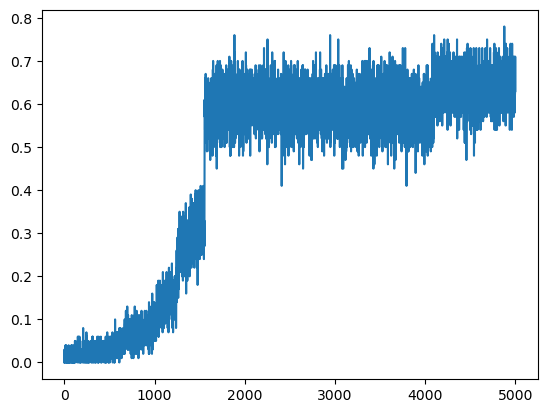

In [35]:
for i in range(n_games):
    done = False
    obs = env.reset()[0]
    score = 0
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, truncated, info = env.step(action)
        agent.learn(obs, action, reward, obs_)
        agent.decrement_epsilon()
        score += reward
        obs = obs_
        done = done or truncated  # Ensure the loop exits if the episode is truncated

    scores.append(score)
    if i % 100 == 0:
        average = np.mean(scores[-100:])
        win_pct_list.append(average)
        if i % 100000 == 0:
            print('episode', i, 'win pct %.2f' % average, 'epsilon %.2f' % agent.eps)

plt.plot(win_pct_list)
plt.show()